Found 227 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


C:\Users\hp\anaconda3\envs\TensorFlow\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


Epoch 1/3
227/227 [==============================] - 11538s 51s/step - loss: 0.5457 - acc: 0.7307 - val_loss: 1.7668 - val_acc: 0.6458
Epoch 2/3
227/227 [==============================] - 11219s 49s/step - loss: 0.3586 - acc: 0.8412 - val_loss: 3.0527 - val_acc: 0.6458
Epoch 3/3
227/227 [==============================] - 11181s 49s/step - loss: 0.2539 - acc: 0.8936 - val_loss: 4.8130 - val_acc: 0.6458
dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


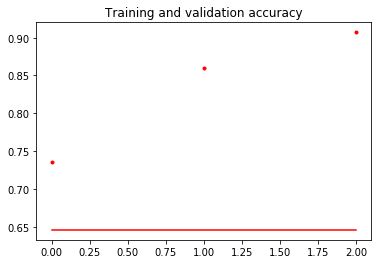

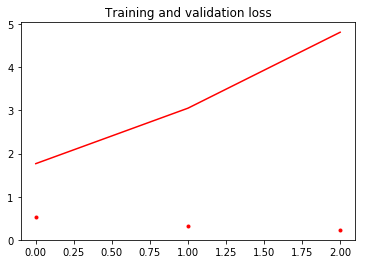

NameError: name 'history_ft' is not defined

<Figure size 432x288 with 0 Axes>

In [2]:
#!/usr/bin/env python2
import os

import glob  #Return a possibly-empty list of path names that match pathname, which must be a string containing a path specification

import matplotlib.pyplot as plt   # Python 2D plotting library which produces publication quality figures. Combine numpy and matplotlib
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import densenet,preprocess_input
from keras.models import Model               
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD


IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for DenseNet
NB_EPOCHS =3     #no.of epochs
BAT_SIZE = 32    #how many images used for one epoch
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172


def get_nb_files(directory):
  """Get number of files by searching directory recursively"""
  if not os.path.exists(directory):
    return 0
  cnt = 0
  for r, dirs, files in os.walk(directory):
    for dr in dirs:
      cnt += len(glob.glob(os.path.join(r, dr + "/*")))
  return cnt


def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


def add_new_last_layer(base_model, nb_classes):
  """Add last layer to the convnet

    base_model: keras model excluding top
    nb_classes: # of classes - Normal and Abnormal

  Returns:
    new keras model with last layer
  """

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
  predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = Model(input=base_model.input, output=predictions)
  return model


def setup_to_finetune(model):
  """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers."""
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


def train():
  """Use transfer learning and fine-tuning to train a network on a new dataset"""
  train_dir = 'train_dir'
  val_dir='val_dir'
  nb_epoch = 3
  batch_size=32
  nb_train_samples = get_nb_files(train_dir)
  nb_classes = len(glob.glob(train_dir + "/*"))
  nb_val_samples = get_nb_files(val_dir)
 
  # data prep
  train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=5,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=False )
  validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=5,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2, horizontal_flip=False)

  train_generator = train_datagen.flow_from_directory(train_dir,target_size=(IM_WIDTH, IM_HEIGHT),batch_size=batch_size)

  validation_generator = validation_datagen.flow_from_directory( val_dir,target_size=(IM_WIDTH, IM_HEIGHT),batch_size=batch_size)

  # setup model
  base_model = DenseNet121(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
  model = add_new_last_layer(base_model, nb_classes)


  # transfer learning
  setup_to_transfer_learn(model, base_model)

  history_tl = model.fit_generator( train_generator,steps_per_epoch=nb_train_samples,epochs=nb_epoch,validation_data=validation_generator,validation_steps=nb_val_samples, class_weight='auto')
 
  
  model.save('densenetmodel.h5')
  
  #ploting grapghs     

  print(history_tl.history.keys())
  acc = history_tl.history['acc']
  val_acc = history_tl.history['val_acc']
  loss = history_tl.history['loss']
  val_loss = history_tl.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  plt.savefig('plot')


if __name__=="__main__":
  train()